# Regressão Logística I

Índice

#### 1. [Análise descritiva](#1)  
1.1. [Bivariada](#1.1)  
1.2. [Medida de risco do evento](#1.2)  
1.3. [Chance de evento](#1.3)  
1.4. [Razão de chances (*odds ratio*)](#1.4)  
1.5. [Bivariada para variáveis contínuas](#1.5)  

#### 2. [Regressão logística](#2)  
2.1 [Função logística](#2.1)  
2.2 [Regressão logística com uma variável](#2.2)  
2.3 [Obtendo os parâmetros](#2.3)  
2.4 [Modelo com mais variáveis](#2.4)  
2.5 [Qualidade do modelo](#2.5)  

## 1. Introdução

Antes de rodar a regressão, vamos entender a análise básica sobre o problema, e alguns indicadores que sãomuito úteis para entender variáveis binárias, e vão ser muito úteis para entendermos a regressão logística.

Vamos entender a análise primeiramente com base em uma tabela de frequências em uma base já conhecida.

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 1.1 Análise bivariada<a name="1.1"></a>
[Índice](#topo)  

A descritiva básica é baseada na tabela cruzada. Em seguida, vamos levantar alguns indicadores que nos ajudam a resumir e entender essa tabela, e se conectam com o modelo de regressão logística de uma forma muito interessante.

Vamos ilustrar com um exemplo, e a fórmula genérica será baseada na tabela abaixo:

| perfil | não evento      | evento      | total    |
|--------|----------|----------|----------|
| **P1** | $a_{11}$ | $a_{12}$ | $a_{1.}$ |
| **P2** | $a_{21}$ | $a_{22}$ | $a_{2.}$ |
| **Total** | $a_{.1}$ | $a_{.2}$ | $a_{..}$ |

In [7]:
titanic = sns.load_dataset('titanic')

In [8]:
tab = pd.crosstab(titanic['sex'], titanic['survived'], margins= True)
tab

survived,0,1,All
sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


### 1.2 Medida de risco do evento<a name="1.2"></a>
[Índice](#topo)  

O *risco* do evento é um sinônimo para a probabilidade de ocorrência de um evento, em geral quando esse evento tem uma conotação negativa (ex: inadimplência, fraude, morte etc).

No exemplo da nossa tabela, o "risco" sobreviver para passageiros do sexo feminino é:

$$P(sobreviver|feminino) = \dfrac{a_{12}}{a_{1.}} = \dfrac{233}{314} = 74\%$$

Observe que a probabilidade de **não sobreviver** (chamamos também não evento) pode ser escrita simplesmente como 1-P.

**Observação:**

- Quanto mais diferentes os riscos entre os perfis, maior o indício de relevância da variável para um modelo de classificação

In [10]:
tab['probabilidade'] = tab[1]/tab['All']
tab

survived,0,1,All,probabilidade
sex,,,,
female,81,233,314,0.742038
male,468,109,577,0.188908
All,549,342,891,0.383838


### 1.3 Chance (*Odds*)<a name="1.3"></a>
[Índice](#topo)  

Chance é uma medida de incerteza assim como probabilidade, mas de uma forma um pouco diferente. A chance de um evento é definida como o número de possibilidades para o evento dividido pelo número de possibilidades para o seu complementar. Por exemplo, a **chance** de tirar **6** em um dado é de **1 / 5** - dizemos **um para cinco**.

Na nossa tabela, a chance de **sobrevivência** para passageiros do sexo **feminino** pode ser calculada por:

$$Odds(feminino) = \dfrac{a_{12}}{a_{11}} = \dfrac{233}{81} = 2.9$$

Quando o evento é raro, o risco (ou probabilidade) do evento se aproximam numericamente do *odds*.

Vamos calcular na nossa tabela:

In [12]:
tab['chance'] = tab[1]/tab[0]
tab

survived,0,1,All,probabilidade,chance
sex,,,,,
female,81,233,314,0.742038,2.876543
male,468,109,577,0.188908,0.232906
All,549,342,891,0.383838,0.622951


In [13]:
2.87/0.23

12.478260869565217

### 1.4 Razão de chances (*odds ratio*)<a name="1.4"></a>
[Índice](#topo)  

A razão de chances é o que o nome diz: uma razão entre chances. Vamos entendê-la:

A razão de chances de **sobrevivênciai** de um passageiroo do sexo **feminino** com relação à chance de **sobrevivênciai** de um passageiro doo sexo **masculino** é de ```2,9/0,2 = 12,3```. Significa que uma **mulher** possui ```12.3``` vezes a chance de **sobrevivência** de homem.

Lembre-se disso: A razão de chances sempre compara as chances de um evento para dois públicos.

Na nossa tabela conceitual a fórmula fica assim:

$$ RC(P1/P2) = \dfrac{\dfrac{a_{12}}{a_{11}}}{{\dfrac{a_{22}}{a_{21}}}} = \dfrac{Odds(P1)}{Odds(P2)}$$

In [15]:
tab.loc['male','chance']

0.2329059829059829

In [16]:
tab['RC_vs_male'] = tab['chance']/tab.loc['male','chance']
tab

survived,0,1,All,probabilidade,chance,RC_vs_male
sex,,,,,,
female,81,233,314,0.742038,2.876543,12.350663
male,468,109,577,0.188908,0.232906,1.000000
All,549,342,891,0.383838,0.622951,2.674688


#### Relação entre chance e probabilidade

Repare que a chance que escrevemos como:

$$chance = \dfrac{223}{81}$$

Também pode ser escrita assim:

$$chance = \dfrac{223}{81} = \dfrac{\dfrac{223}{314}}{\dfrac{81}{314}} = \dfrac{P(sobreviver|feminino)}{1-P(sobreviver|feminino)}$$

ou, de forma genérica:

$$chance = \dfrac{\dfrac{a_{12}}{a_{1.}}}{\dfrac{a_{11}}{a_{1.}}} = \dfrac{P(sem\_veículo)}{1-P(sem\_veículo)}$$

A chance pode também ser escrita assim:

$$Chance = \dfrac{P}{1-P} $$



## 2. Regressão logística<a name="2"></a>
[Índice](#topo)  

É a técnica estatística mais popular para modelagem preditiva de eventos binários. Assim como a regressão, é um modelo linear - o que significa que é definida por uma equação linear, ou seja uma equação da forma  

$g(y)=\alpha + \beta_1 x_1 + \beta_2 x_2 +...+ \beta_p x_p = \eta$  

Em que $\alpha, \beta_1, \beta_2,... \beta_p$ são constantes.

Portanto, a regressão logística compartilha uma série de características e ferramentas com os modelos de regressão linear, mas com particularidades para a resposta binária.

### 2.1 Função logística<a name="2.1"></a>
[Índice](#topo)  

O *logito* é a *função de ligação* que modelamos na regressão logística. É definido como o **logaritmo da chance**, ou ainda:

$$logito=log\left(\frac{p}{1-p}\right) $$

O que nos dá a seguinte equação:

$$log\left(\frac{p}{1-p}\right) = \alpha + \beta_1 x_1 + \beta_2 x_2 +...+ \beta_p x_p$$

- Quando P se aproxima de 0, o logito *vai para* $-\infty$.  
- Quando P se aproxima de 1, o logito *vai para* $+\infty$.  
- Não se define quando P=0 ou quando P=1.

Vamos observar isso graficamente:

In [20]:
P = pd.Series(np.linspace(0.001,.999,1000))
P

0      0.001000
1      0.001999
2      0.002998
3      0.003997
4      0.004996
         ...   
995    0.995004
996    0.996003
997    0.997002
998    0.998001
999    0.999000
Length: 1000, dtype: float64

In [21]:
logito = np.log(P/(1-P))

plt.plot(P, logito, 'r');

#### Transformação inversa do logito

O nosso modelo linear vai nos fornecer uma estimativa do logito para cada perfil de interesse. Podemos *voltar* na probabilidade com a função inversa do logito. Com um pouco de álgebra, chegamos nessa equação aqui:


$$
    p = \frac{1}{\left(1+e^{-\eta}\right)}
$$


In [23]:
plt.plot(logito, P, 'r')

### 2.2 Regressão logística com uma variável <a name="2.2"></a>
[Índice](#topo)  

A nossa regressão, como já falamos, é um modelo linear sobre uma função da probabilidade - essa função é o logito. Com uma variável, a equação da regressão logística que dá a probabilidade $P_i$ de default para cada cliente i=1, 2, ...N é:

$$ log\left(\dfrac{P_i}{\left(1-P_i\right)}\right) = \alpha + \beta x_i $$

Repare que se quisermos a chance para cada perfil, basta aplicar a função exponencial dos dois lados:

$$ \dfrac{P_i}{\left(1-P_i\right)} = e^{\alpha + \beta x_i} $$

Se quisermos as probabilidades, basta isolar o P na equação e obter:

$$ P_i = \dfrac{1}{1 + e^{- (\alpha + \beta x_i)}} $$



Vamos explorar a regressão logística com a variável do exemplo anterior para entender a equação.


In [25]:
import statsmodels.formula.api as smf

reglog = smf.logit("survived ~ sex",data=titanic).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jul 2024   Pseudo R-squ.:                  0.2266
Time:                        19:27:14   Log-Likelihood:                -458.90
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.020e-60
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0566      0.129      8.191      0.000       0.804       1.309
sex[T.male]    -2.5137      0.167    -15.036      0.000      -2.841      -2.186
===============================================================================
"""

### 2.3 Obtendo as probabilidades estimadas<a name="2.3"></a>
[Índice](#topo)  

Além dos atributos que mencionamos e exploramos anteriormente, o objeto que armazena a regressão logística possui diversos métodos que fazem operações importantes como a aplicação da regra do modelo a uma base de dados. Essa base, no entanto, deve ter as mesmas variáveis nos mesmos nomes e formatos daquelas utilizadas na construção do modelo.

Assim, podemos calcular as probabilidades de evento para cada perfil "na mão" ou utilizando o método ```.predict()```.


In [27]:
reglog.params[1]

C:\Users\Hanga\AppData\Local\Temp\ipykernel_29256\1638984751.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reglog.params[1]


-2.5137097125817633

In [28]:
eta = reglog.params[0] + reglog.params[1]
eta

C:\Users\Hanga\AppData\Local\Temp\ipykernel_29256\2768061096.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta = reglog.params[0] + reglog.params[1]


-1.4571204136885025

In [29]:
chance = np.exp(eta)
chance

0.23290598290598302

In [30]:
p = 1/(1 + np.exp(-eta))
p

0.18890814558058933

#### Escorando a base com .predict()

In [32]:
titanic['predito'] = reglog.predict(titanic)

titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,predito
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0.188908
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,0.742038
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0.742038
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,0.742038
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0.188908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,0.188908
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,0.742038
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False,0.742038
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True,0.188908


### 2.4 Modelo com mais variáveis<a name="2.4"></a>
[Índice](#topo)  

Vamos rodar um modelo mais completo nessa base. A estrutura é essencialmente a mesma, mas com mais variáveis.

$$ log\left(\dfrac{P_i}{1-P_i}\right) = \alpha + \beta_1 x_{i1}  + \beta_2 x_{i2} + ... + \beta_p x_{ip}$$

In [34]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,predito
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0.188908
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,0.742038
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0.742038
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,0.742038
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0.188908


In [35]:
reglog = smf.logit(" survived ~ sex + C(pclass) + fare"
                   , data=titanic).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.463592
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      886
Method:                           MLE   Df Model:                            4
Date:                Sat, 06 Jul 2024   Pseudo R-squ.:                  0.3038
Time:                        19:27:15   Log-Likelihood:                -413.06
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 9.314e-77
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.1476      0.278      7.716      0.000       1.602       2.693
sex[T.male]       -2.6246      0.185    -14.170      0.000      -2.988      -2.262
C(pclass)[T.2]    -0.7366      0.271     -2.717      0.007      -1.268      -0.205
C(pclass)[T.3]    -1.7903      0.252     -7.111      0.000      -2.284      -1.297
fare               0.0018      0.002      0.864      0.388      -0.002       0.006
==================================================================================
"""

In [36]:
np.exp(-65*.0112)

0.48287377253122976

In [37]:
eta = 2.2971 + (-2.6419) + (-1.9055)
chance = np.exp(eta)
prob = 1/(1+np.exp(-eta))
prob

0.09532359065697854

In [38]:
1/np.exp(-2.6419)

14.03985400444786

In [39]:
np.exp(-1.9055)

0.14874824990055957

### 2.5 Qualidade do modelo <a name="2.5"></a>
[Índice](#topo)  

Eixos de qualidade de um modelo:

- Calibragem: O quanto uma estimativa de probabilidade de evento esta próxima da realidade.
- Discriminação: O quanto o modelo consegue discriminar "eventos" de "não eventos" com probabilidades bem distintas.
- Estabilidade: A qualidade do modelo de ter pouca variabilidade temporal.
- Operacional: O quanto de pode confiar operacionalmente no modelo (consistência dos dados, infra-estrutura confiável, etc).

In [41]:
titanic['predito'] = reglog.predict(titanic)
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,predito
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0.094982
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,0.906951
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0.591848
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,0.904127
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0.095107


#### Calibragem

In [43]:
cat_pred = pd.qcut(titanic['predito'], 5, duplicates='drop')
cat_pred.value_counts().sort_index()

predito
(0.0929, 0.0951]    181
(0.0951, 0.232]     188
(0.232, 0.408]      166
(0.408, 0.603]      178
(0.603, 0.956]      178
Name: count, dtype: int64

In [44]:
group_reg = titanic.groupby(cat_pred)
qualid = group_reg[['survived']].count().rename(columns = {'survived': 'contagem'})
qualid

C:\Users\Hanga\AppData\Local\Temp\ipykernel_29256\4111493133.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_reg = titanic.groupby(cat_pred)


,contagem
predito,
"(0.0929, 0.0951]",181
"(0.0951, 0.232]",188
"(0.232, 0.408]",166
"(0.408, 0.603]",178
"(0.603, 0.956]",178


In [45]:
qualid['predito'] = group_reg['predito'].mean()
qualid

,contagem,predito
predito,,
"(0.0929, 0.0951]",181,0.095004
"(0.0951, 0.232]",188,0.112533
"(0.232, 0.408]",166,0.313900
"(0.408, 0.603]",178,0.558316
"(0.603, 0.956]",178,0.854834


In [46]:
qualid['pct_sobrev'] = group_reg['survived'].mean()
qualid

,contagem,predito,pct_sobrev
predito,,,
"(0.0929, 0.0951]",181,0.095004,0.104972
"(0.0951, 0.232]",188,0.112533,0.159574
"(0.232, 0.408]",166,0.313900,0.265060
"(0.408, 0.603]",178,0.558316,0.483146
"(0.603, 0.956]",178,0.854834,0.915730


In [47]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_sobrev'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')


Text(0.5, 0, 'Grupo')

#### Discriminação

Curva ROC

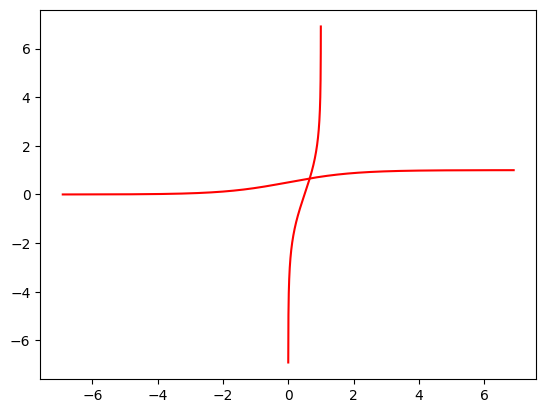

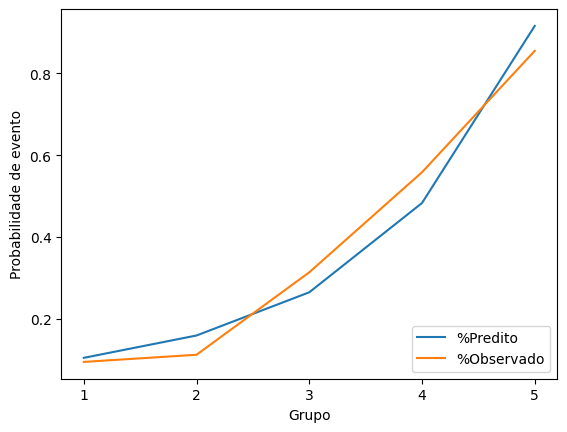

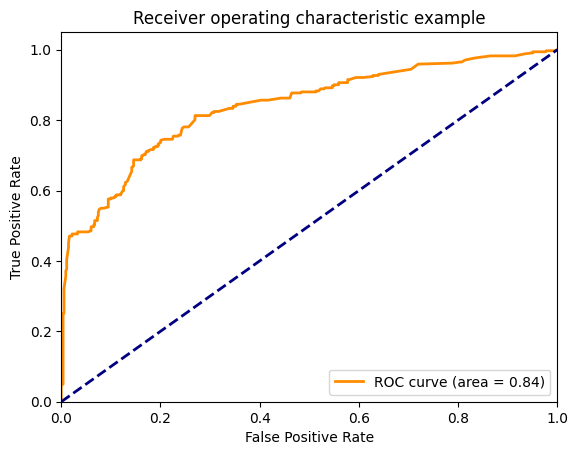

In [50]:
from sklearn.metrics import roc_curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(titanic['survived'], titanic['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(titanic['survived'], titanic['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



Gráfico do KS

In [52]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = titanic.loc[titanic['survived']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Sobreviventes')

score_pop2 = titanic.loc[titanic['survived']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não sobreviventes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')


Text(0, 0.5, 'Função Distribuição Acumulada')

#### Indicadores

In [54]:
from sklearn import metrics
from scipy.stats import ks_2samp

acc = metrics.accuracy_score(titanic['survived'], titanic['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(titanic['survived'], titanic['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(titanic.loc[titanic['survived'] == 1, 'predito'], titanic.loc[titanic['survived'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 78.68%
KS: 54.33% 
AUC: 83.77% 
GINI: 67.55%
